## ARIMA

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Loading data

In [3]:
data = pd.read_csv('traffic.csv', parse_dates=["DateTime"], index_col="DateTime")
data.sort_index(inplace=True)

In [4]:
df_1 = data[data['Junction']==1]

### Vehicles over Time (Hourly) plot

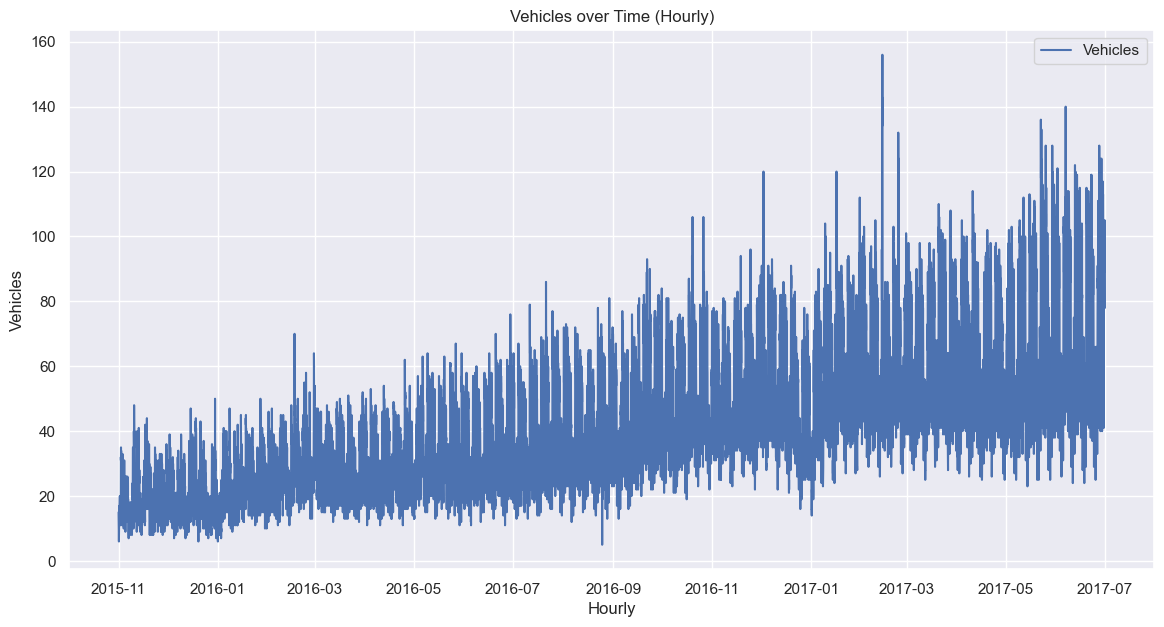

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df_1.index, df_1["Vehicles"], label='Vehicles')
plt.title('Vehicles over Time (Hourly)')
plt.xlabel('Hourly')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

### Hourly decomposition

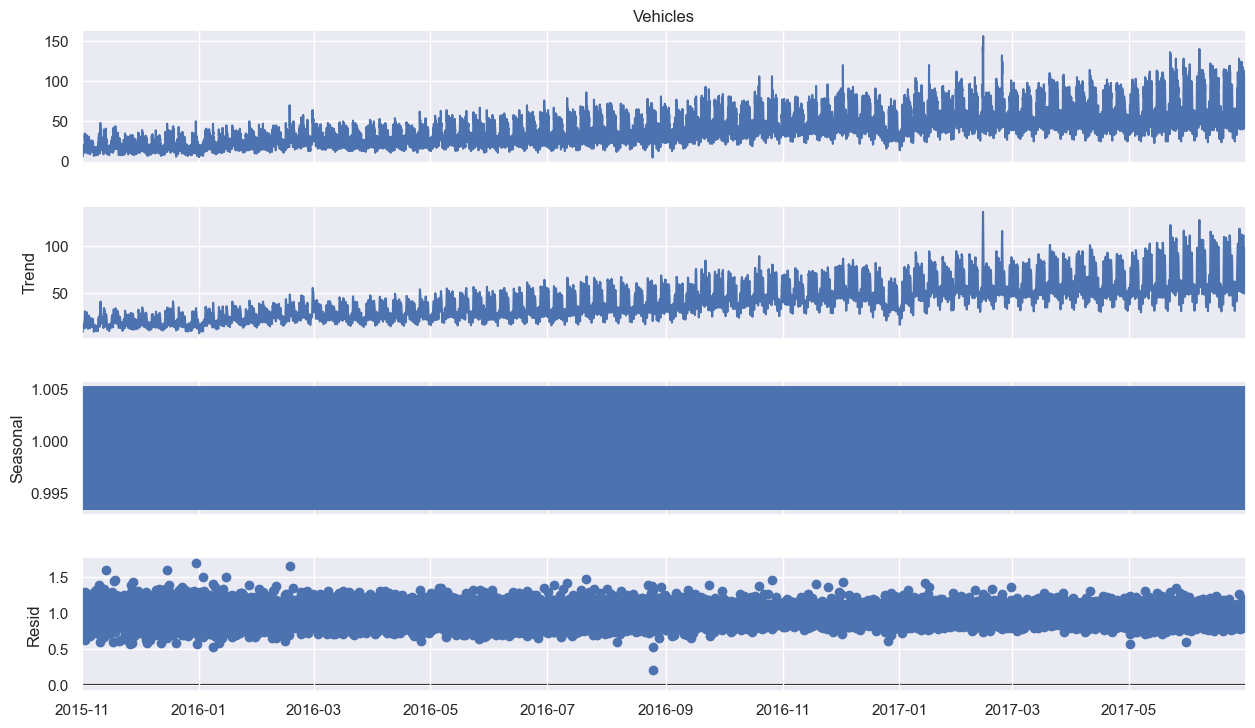

In [ ]:
# import matplotlib.pyplot as plt
# import statsmodels.api as sm

dec = sm.tsa.seasonal_decompose(df_1['Vehicles'], period=7, model='multiplicative')
fig = dec.plot()
fig.set_size_inches(14, 8)  # set desired figure size
plt.show()


### Vehicles over Time (Daily) plot

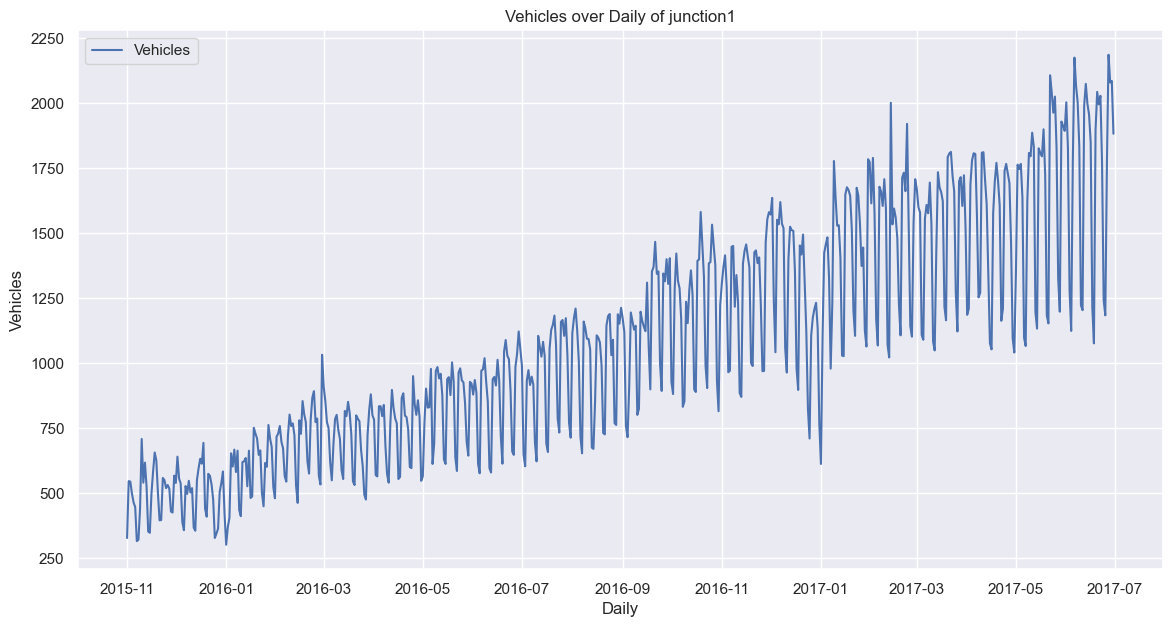

In [14]:
# Perform the Augmented Dickey-Fuller test on the original series
daily_traffic = df_1['Vehicles'].resample('D').sum()
daily_traffic_df = daily_traffic.to_frame().copy()
plt.figure(figsize=(14, 7))
plt.plot(daily_traffic_df.index, daily_traffic_df["Vehicles"], label='Vehicles')
plt.title('Vehicles over Daily of junction1')
plt.xlabel('Daily')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

### Daily Decomposition

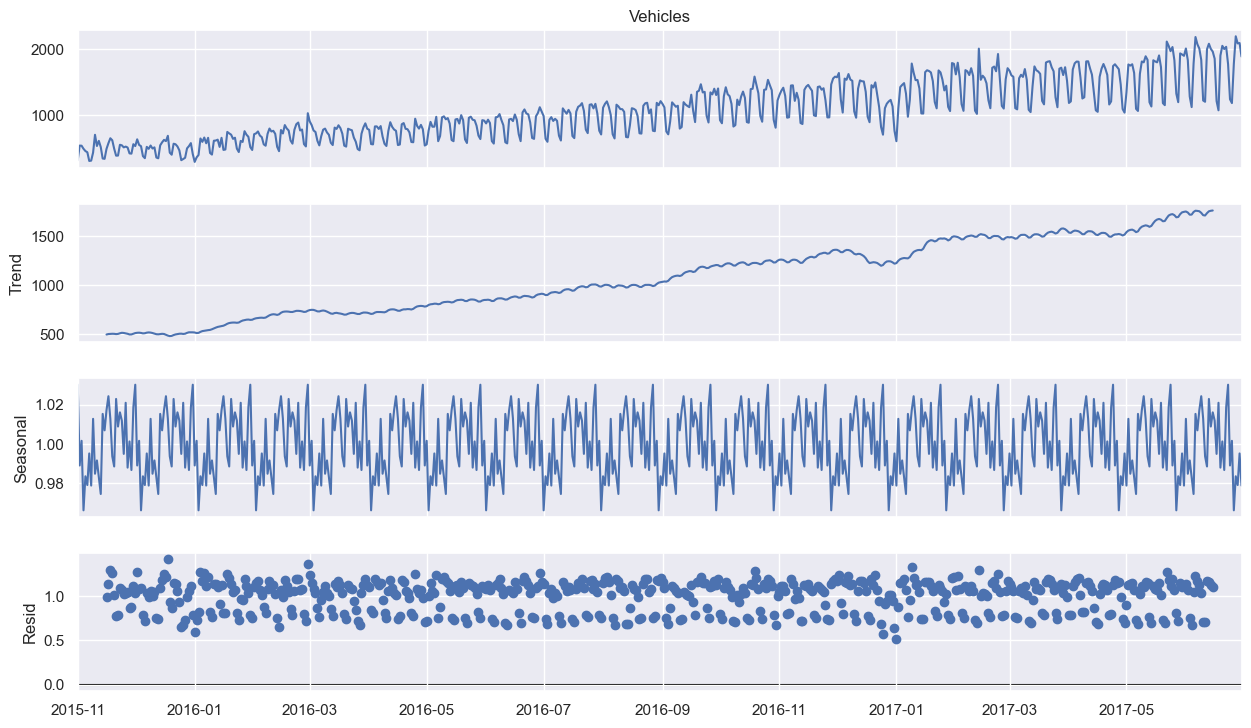

In [16]:
dec = sm.tsa.seasonal_decompose(daily_traffic_df['Vehicles'],period = 30, model = 'multiplicative')
fig = dec.plot()
fig.set_size_inches(14, 8)
plt.show()

### Check Stationary

In [17]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(daily_traffic_df)

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
daily_traffic_df['Vehicles_Diff'] = daily_traffic_df.diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(daily_traffic_df["Vehicles_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -0.3414
p-value (Original): 0.9194
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -8.9226
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


### Differenced Vehicles Over Time plot

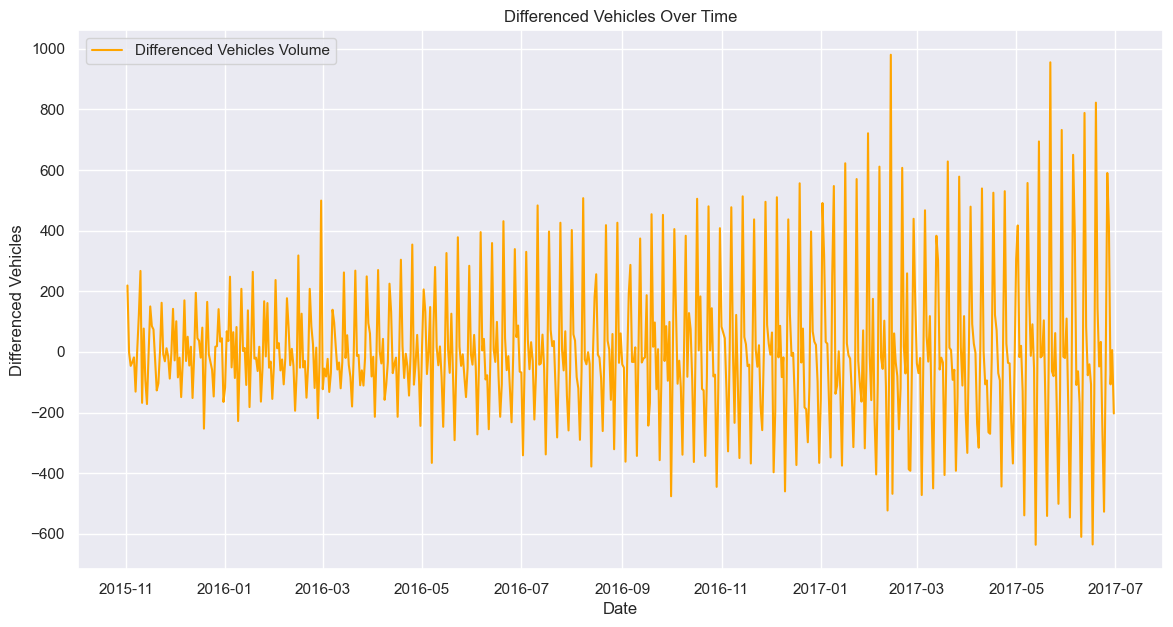

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(daily_traffic_df.index, daily_traffic_df['Vehicles_Diff'], label='Differenced Vehicles Volume', color='orange')
plt.title('Differenced Vehicles Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Vehicles')
plt.legend()
plt.show()

### ACF plot (Hourly)

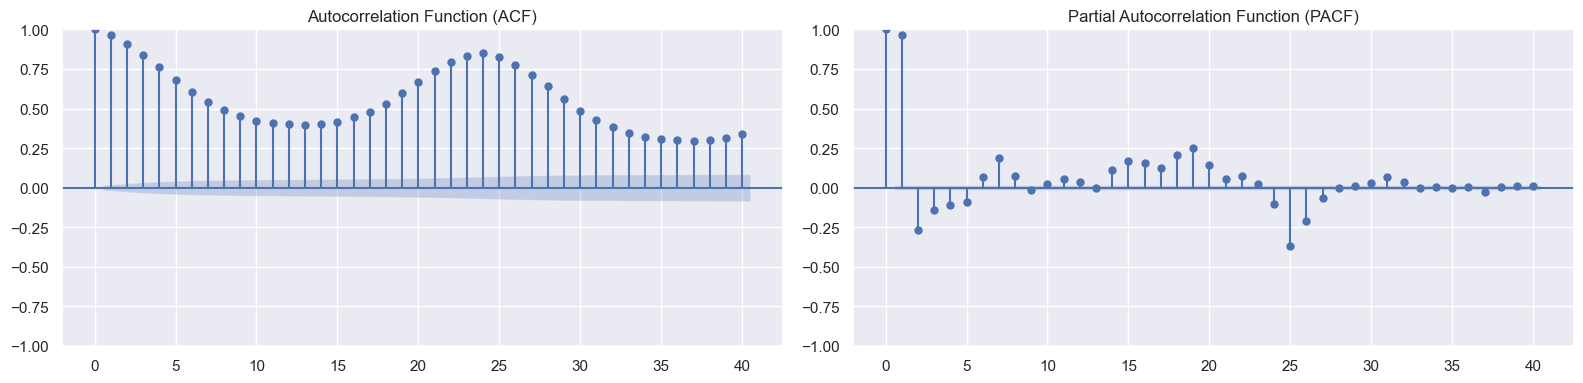

In [19]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(df_1['Vehicles'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df_1['Vehicles'], lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### ACF plot (Daily)

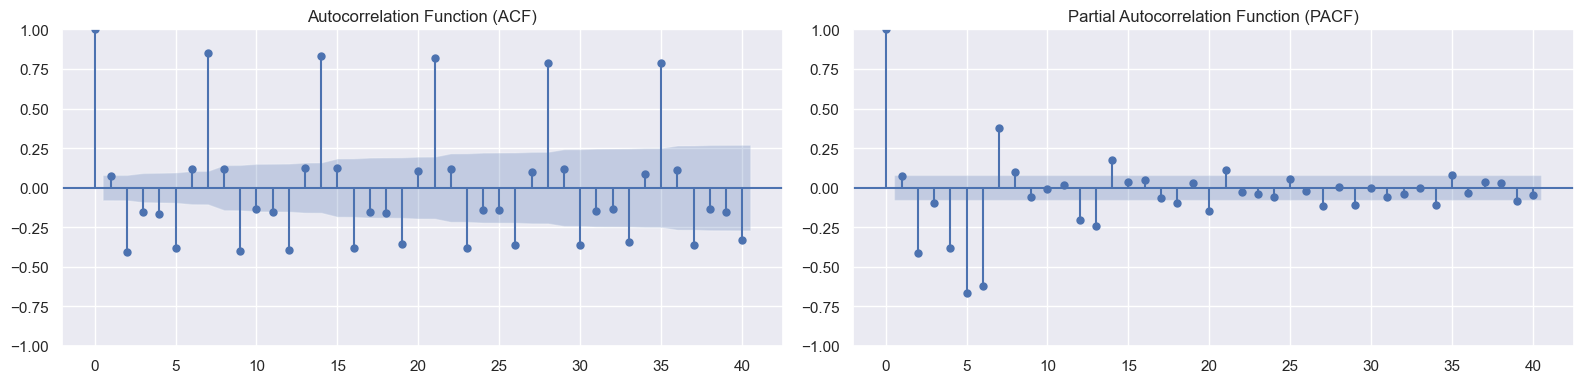

In [20]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(daily_traffic_df['Vehicles_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(daily_traffic_df['Vehicles_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### Split data into train and test

In [21]:
train_size = int(len(daily_traffic_df) * 0.8)
train, test = daily_traffic_df.iloc[:train_size], daily_traffic_df.iloc[train_size:]

## Fit ARIMA model

In [22]:
sarima_model = SARIMAX(daily_traffic, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit()

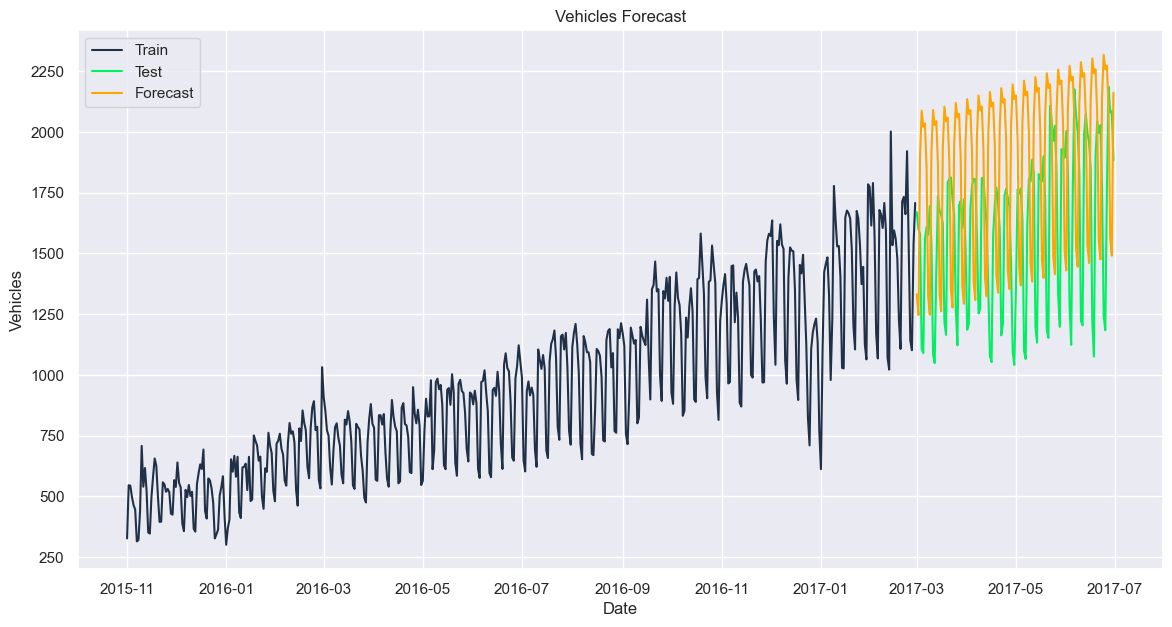

In [23]:
# Forecast
forecast = sarima_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train['Vehicles'], label='Train', color='#203147')
plt.plot(test.index, test['Vehicles'], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Vehicles Forecast')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

In [24]:
print(f"AIC: {sarima_fit.aic}")
print(f"BIC: {sarima_fit.bic}")

AIC: 7011.823956030925
BIC: 7033.808604307005


In [25]:
forecast = forecast[:len(test)]
test = test["Vehicles"][:len(forecast)]

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 533.4863
MSE: 389013.9653
RMSE: 623.7098
R² Score: -2.8344


In [26]:
# Fit SARIMA model on hourly data (using 24-hour seasonality)
sarima_hourly_model = SARIMAX(df_1['Vehicles'].resample('D').mean(), order=(1, 1, 1), seasonal_order=(1, 0, 1, 7))
sarima_hourly_fit = sarima_hourly_model.fit()

C:\Users\MSI PC\AppData\Local\Temp\ipykernel_12588\3673680432.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_hourly_dates = pd.date_range(start=df_1['Vehicles'].index[-1] + pd.Timedelta(hours=1), periods=forecast_hours, freq='H')


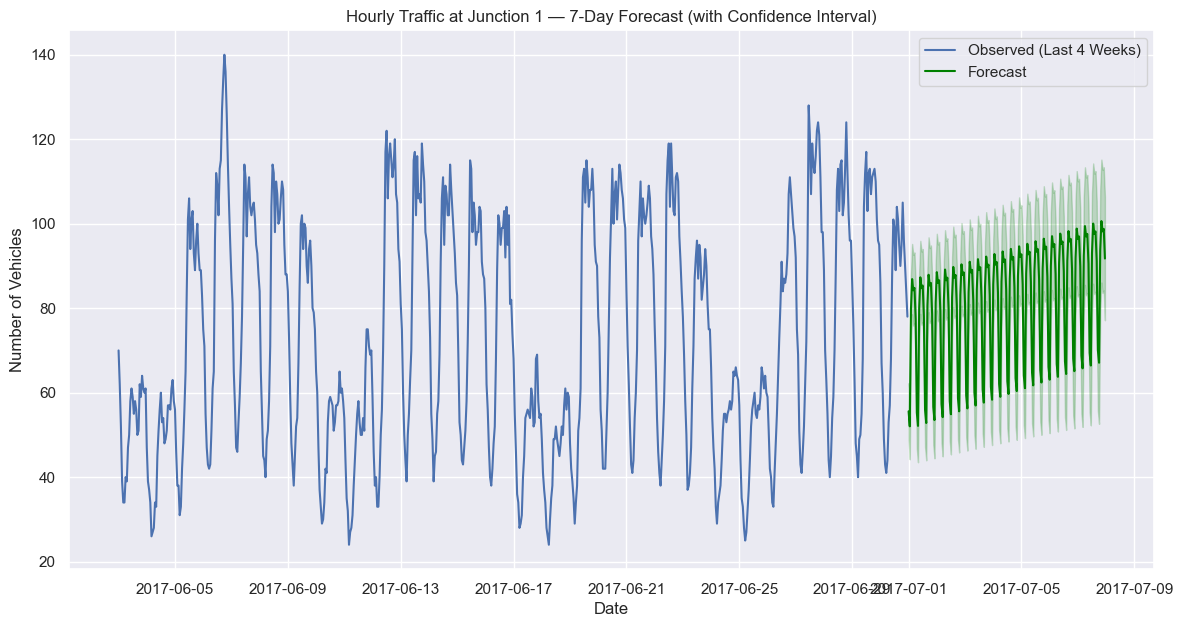

In [28]:
# Forecast next 7 days (7*24 = 168 hours)
forecast_hours = 7 * 24
sarima_hourly_forecast = sarima_hourly_fit.get_forecast(steps=forecast_hours)
forecast_hourly_mean = sarima_hourly_forecast.predicted_mean
forecast_hourly_ci = sarima_hourly_forecast.conf_int()

# Prepare plotting
forecast_hourly_dates = pd.date_range(start=df_1['Vehicles'].index[-1] + pd.Timedelta(hours=1), periods=forecast_hours, freq='H')
forecast_hourly_mean.index = forecast_hourly_dates
forecast_hourly_ci.index = forecast_hourly_dates

# Extract numpy values for plotting
lower_ci_vals = forecast_hourly_ci.iloc[:, 0].values
upper_ci_vals = forecast_hourly_ci.iloc[:, 1].values

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df_1['Vehicles'][-7*24*4:], label='Observed (Last 4 Weeks)')  # last 4 weeks for context
plt.plot(forecast_hourly_mean, label='Forecast', color='green')
plt.fill_between(forecast_hourly_mean.index, lower_ci_vals, upper_ci_vals, color='green', alpha=0.2)
plt.title('Hourly Traffic at Junction 1 — 7-Day Forecast (with Confidence Interval)')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()


## AUTO ARIMA

### Import Libraries

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
sns.set()
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [14]:
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'

### Loading Data

In [2]:
data = pd.read_csv('traffic.csv', parse_dates=['DateTime'])
junction_1_data = data[data['Junction'] == 1].copy()
junction_1_data = junction_1_data.sort_values('DateTime')
junction_1_data.set_index('DateTime', inplace=True)

### Resample (Hourly to Daily)

In [3]:
junction_1_data = junction_1_data
junction_1_data['Vehicles'] = junction_1_data['Vehicles'].astype('float32')
junction_1_data = junction_1_data.asfreq('H')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15020\3935910328.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  junction_1_data = junction_1_data.asfreq('H')


### Train/Test split

In [4]:
train_size = int(len(junction_1_data) * 0.9)
train, test = junction_1_data['Vehicles'][:train_size], junction_1_data['Vehicles'][train_size:]

### Model Building

In [5]:
model = pm.auto_arima(
    train,
    seasonal=True,
    m=24,  # Daily seasonality for hourly data
    max_order=5,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=1,
    start_Q=0, max_Q=1,
    d=None,  # Let Auto ARIMA determine differencing
    D=None,  # Let Auto ARIMA determine seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=83825.070, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=79100.551, Time=9.73 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=81114.357, Time=9.52 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=83823.071, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=83226.929, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=37.13 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=81109.433, Time=9.02 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=79320.398, Time=5.66 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=79088.486, Time=13.85 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=83080.868, Time=0.59 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=49.95 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=81037.354, Time=11.00 sec
 ARIMA(2,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=59.39 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=53.54 sec
 ARIMA(2,1,0)(1,0,0)[24

In [6]:
# Print model summary
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                13132
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 24)   Log Likelihood              -39539.243
Date:                            Wed, 21 May 2025   AIC                          79086.487
Time:                                    21:52:36   BIC                          79116.418
Sample:                                11-01-2015   HQIC                         79096.482
                                     - 05-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1574      0.006    -26.652      0.000      -0.169      -0.146
ar.L2         -0.0351      0.007   

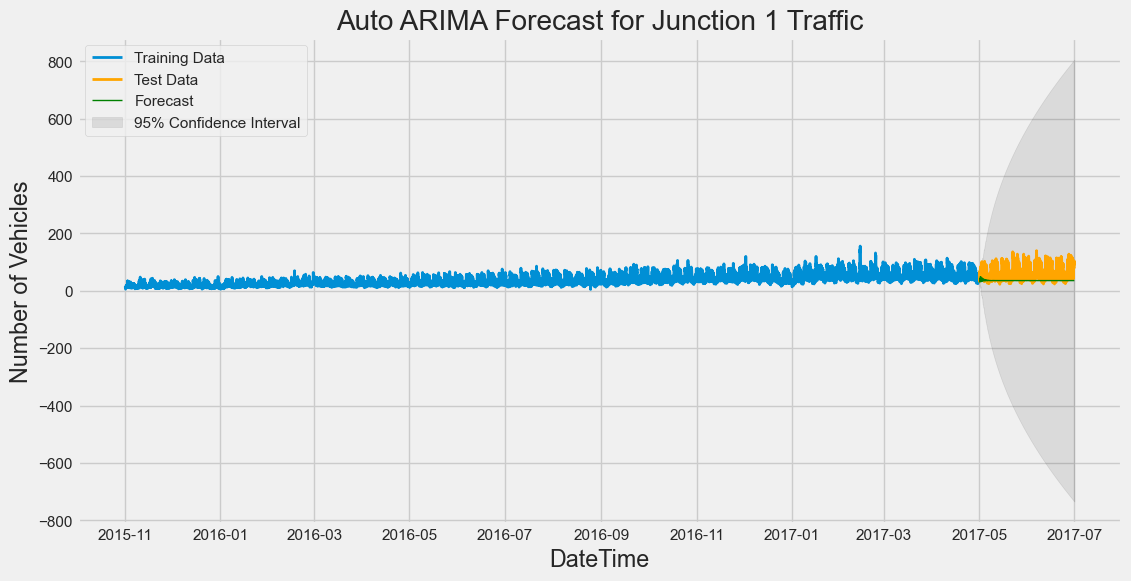

In [7]:
# Forecast for the length of the test set
# Step 5: Plot the results
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', ms=1, lw=2)
plt.plot(test.index, test, label='Test Data', color='orange', ms=1, lw=2)
plt.plot(test.index, forecast, label='Forecast', color='green', ms=1, lw=1)
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1, label='95% Confidence Interval')
plt.title('Auto ARIMA Forecast for Junction 1 Traffic')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [8]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 35.9305
MSE: 1926.8530
RMSE: 43.8959
R² Score: -1.8021


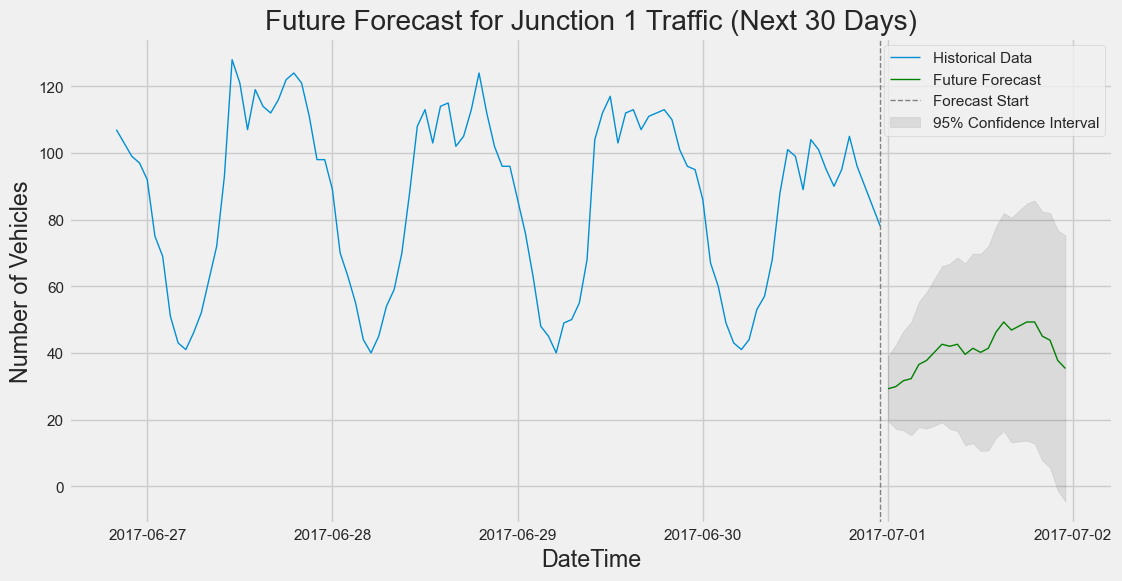

In [9]:
# Optional: Forecast future values (e.g., next 24 hours)
future_forecast, future_conf_int = model.predict(n_periods=24, return_conf_int=True)
future_index = pd.date_range(start=junction_1_data.index[-1] + pd.Timedelta(hours=1), periods=24, freq='h')

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(junction_1_data.index[-100:], junction_1_data['Vehicles'][-100:], label='Historical Data', ms=1, lw=1)
plt.plot(future_index, future_forecast, label='Future Forecast', color='green', ms=1, lw=1)
plt.axvline(x=junction_1_data.index.max(), color='gray', linestyle='--', label='Forecast Start', ms=1, lw=1)
plt.fill_between(future_index, future_conf_int[:, 0], future_conf_int[:, 1], color='k', alpha=0.1, label='95% Confidence Interval')
plt.title('Future Forecast for Junction 1 Traffic (Next 30 Days)')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

## Daily

In [ ]:
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
sns.set()
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [84]:
data = pd.read_csv('traffic.csv', parse_dates=['DateTime'])
junction_1_data = data[data['Junction'] == 1].copy()
junction_1_data = junction_1_data.sort_values('DateTime')
junction_1_data.set_index('DateTime', inplace=True)

In [85]:
junction_1_data = junction_1_data.resample('D').mean()
junction_1_data['Vehicles'] = junction_1_data['Vehicles'].astype('float32')
junction_1_data = junction_1_data.asfreq('D')

In [86]:
train_size = int(len(junction_1_data) * 0.8)
train, test = junction_1_data['Vehicles'][:train_size], junction_1_data['Vehicles'][train_size:]

In [87]:
model = pm.auto_arima(
    train,
    seasonal=True,
    m=7,  # Daily seasonality for hourly data
    max_order=5,
    start_p=0, max_p=2,
    start_q=0, max_q=2,
    start_P=0, max_P=1,
    start_Q=0, max_Q=1,
    d=None,  # Let Auto ARIMA determine differencing
    D=None,  # Let Auto ARIMA determine seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3437.874, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2825.024, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3170.159, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3435.972, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=3439.685, Time=0.05 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2592.274, Time=0.38 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=3175.212, Time=0.18 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2649.712, Time=0.31 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=2578.046, Time=0.41 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=3131.369, Time=0.19 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=2814.757, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=3368.538, Time=0.08 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(2,1,0)(1,0,1)[7]             : AIC=2

In [88]:
# Print model summary
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  486
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1272.159
Date:                           Wed, 21 May 2025   AIC                           2554.318
Time:                                   22:09:48   BIC                           2575.238
Sample:                               11-01-2015   HQIC                          2562.538
                                    - 02-28-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3388      0.062      5.499      0.000       0.218       0.459
ma.L1         -0.7831      0.046    -17.169

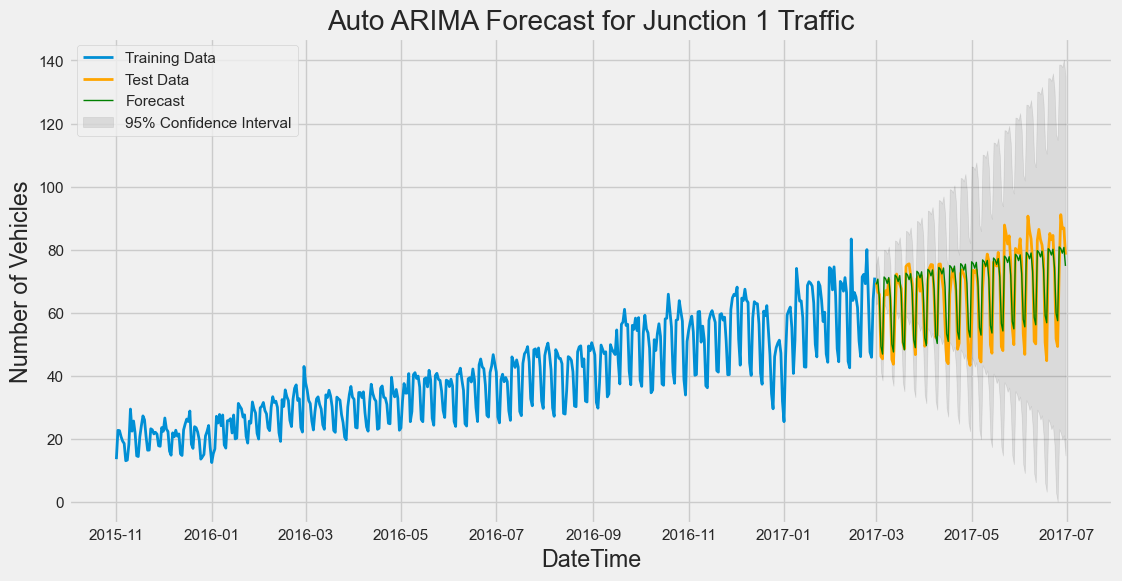

In [89]:
# Forecast for the length of the test set
# Step 5: Plot the results
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', ms=1, lw=2)
plt.plot(test.index, test, label='Test Data', color='orange', ms=1, lw=2)
plt.plot(test.index, forecast, label='Forecast', color='green', ms=1, lw=1)
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1, label='95% Confidence Interval')
plt.title('Auto ARIMA Forecast for Junction 1 Traffic')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

In [90]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 4.3166
MSE: 30.2813
RMSE: 5.5028
R² Score: 0.8281


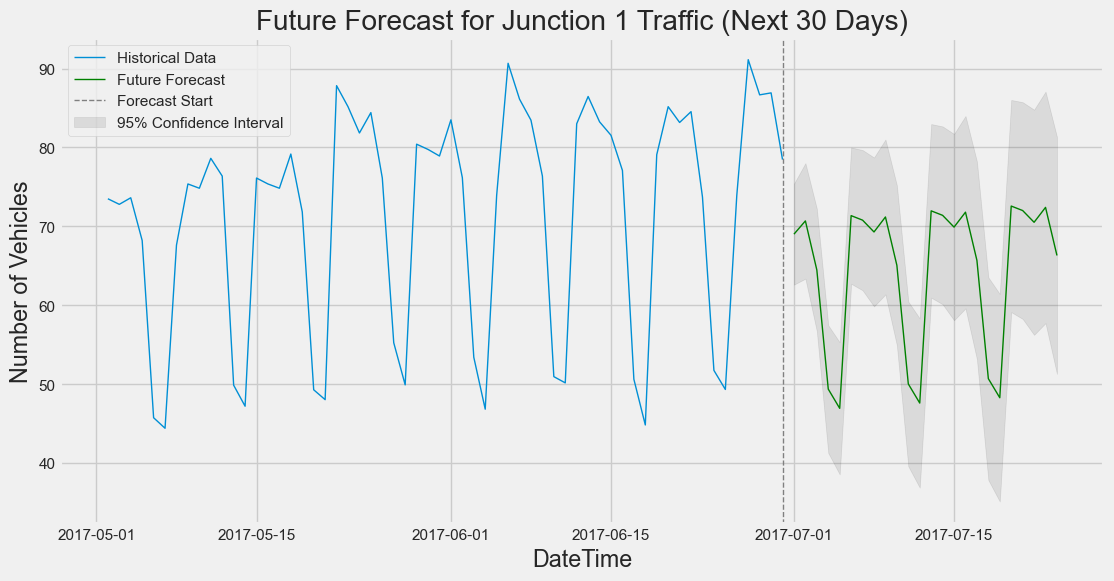

In [91]:
# Optional: Forecast future values (e.g., next 24 hours)
future_forecast, future_conf_int = model.predict(n_periods=24, return_conf_int=True)
future_index = pd.date_range(start=junction_1_data.index[-1] + pd.Timedelta(days=1), periods=24, freq='D')

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(junction_1_data.index[-60:], junction_1_data['Vehicles'][-60:], label='Historical Data', ms=1, lw=1)
plt.plot(future_index, future_forecast, label='Future Forecast', color='green', ms=1, lw=1)
plt.axvline(x=junction_1_data.index.max(), color='gray', linestyle='--', label='Forecast Start', ms=1, lw=1)
plt.fill_between(future_index, future_conf_int[:, 0], future_conf_int[:, 1], color='k', alpha=0.1, label='95% Confidence Interval')
plt.title('Future Forecast for Junction 1 Traffic (Next 30 Days)')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()